In [1]:
# Import T. Kipf's GCN implementation
# https://github.com/tkipf/keras-gcn
import pandas as pd
import numpy as np
import scipy
import time
import random
import sys
import keras
sys.path.append('./keras-gcn/')
from keras.losses import mean_absolute_error
from keras.layers import Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
from kegra.layers.graph import GraphConvolution
from kegra.utils import *
%matplotlib inline

Using TensorFlow backend.


In [2]:
X = pd.read_hdf('history_small.hdf', key='hist') 
A = pd.read_pickle('adjacency_small.pkl') 
A = A[sorted(A.columns)]

In [3]:
X.shape, A.shape

((878, 290), (878, 878))

## Data preprocess

In [4]:
X[X==1] = 10 #10 #valid
X[X==0] = 1 #not valid
#X[X==-100] = 0 #missing
X = X.astype(float)
X[X==-100] = np.nan
#np.unique(X)
X1 = X.copy()

In [5]:
y = X.values.flatten()

#### To find index of student that answered to most questions

In [6]:
for col in X:
    if (len(X[col][X[col]!=0])> 500):
        print(col)
        break

425.0


In [7]:
np.where(X[123482]!=0)[0].shape

(878,)

In [8]:
np.where(X.columns==123482.0)

(array([80]),)

### output : flattened input

In [9]:
#y = X.values.ravel(order = 'F') #len(y) =n*m : 878*290 #rempli en colonne de sorte que 
                                        #per user_id, the responses to all the exercise_id (valid/not valid/missing)
#np.where(y!=0)[0].shape #8821 non null entries (1 or 10)
#y[y==0] = np.nan

In [10]:
l = []
for col in X : 
    a = pd.get_dummies(X[col])
    if (1 not in a.columns) & (10 in a.columns):
        a[1] = np.zeros(a.shape[0],dtype=int)
    if (1 in a.columns) & (10 not in a.columns):
        a[10] = np.zeros(a.shape[0],dtype=int)
    l.append(a[[1,10]])
X = pd.concat(l, axis=1, keys=X.columns)
X.columns = [str(int(col[0]))+'_'+str(col[1]) for col in X.columns.values]

In [11]:
A = scipy.sparse.csr_matrix(A.values)
X = np.asmatrix(X)

In [12]:
print(X.shape,X1.shape, A.shape, y.shape) #n*2m, n*m
print(type(X),type(X1), type(A), type(y)) 

(878, 580) (878, 290) (878, 878) (254620,)
<class 'numpy.matrixlib.defmatrix.matrix'> <class 'pandas.core.frame.DataFrame'> <class 'scipy.sparse.csr.csr_matrix'> <class 'numpy.ndarray'>


## Training GCN

In [13]:
FILTER = 'localpool'  
MAX_DEGREE = 2 
SYM_NORM = True  
NB_EPOCH = 200
PATIENCE = 10  

# Normalize X
X = X/X.sum(1).reshape(-1, 1)

A_ = preprocess_adj(A, SYM_NORM)
support = 1
G = [Input(shape=(None, None), batch_shape=(None, None), sparse=True)]

In [14]:
y_ = pd.get_dummies(y).as_matrix()

idx_train = range(70240,71118)
idx_val = range(70240,71118)
idx_test = range(70240,71118)

y_train = y_[idx_train]
y_test = y_[idx_test]
y_val = y_[idx_val]

### Test encoding

In [15]:
graph_1 = [X1, A_]

In [16]:
X_in_1 = Input(shape=(X1.shape[1],))
H_1 = Dropout(0.5)(X_in_1)
H_1 = GraphConvolution(16, support, activation='relu', W_regularizer=l2(5e-4))([H_1]+G)
H_1 = Dropout(0.5)(H_1)
Y = GraphConvolution(y_.shape[1], support, activation='softmax')([H_1]+G)

In [17]:
def loss_(y_true, y_pred):
    list_ind = np.where(y_train!=0)[0]
    mask = np.zeros((y_train.shape[0],1))
    mask[list_ind] = 1
    #mask = keras.utils.to_categorical(mask)
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

In [18]:
# Compile model
model = Model(inputs=[X_in_1]+G, outputs=Y)
model.compile(loss=loss_, optimizer=Adam(lr=0.01))

wait = 0
preds = None
best_val_loss = 99999

train_mask = sample_mask(np.where(y_train!=0)[0], y_train.shape[0])
h = model.fit(graph_1, y_train, sample_weight=train_mask,
          batch_size=A.shape[0], epochs=100, shuffle=False, verbose=1)

Epoch 1/100
878/878 [==============================] - 0s 439us/step - loss: nan
Epoch 2/100
878/878 [==============================] - 0s 169us/step - loss: nan
Epoch 3/100
878/878 [==============================] - 0s 162us/step - loss: nan
Epoch 4/100
878/878 [==============================] - 0s 162us/step - loss: nan
Epoch 5/100
878/878 [==============================] - 0s 171us/step - loss: nan
Epoch 6/100
878/878 [==============================] - 0s 164us/step - loss: nan
Epoch 7/100
878/878 [==============================] - 0s 169us/step - loss: nan
Epoch 8/100
878/878 [==============================] - 0s 166us/step - loss: nan
Epoch 9/100
878/878 [==============================] - 0s 185us/step - loss: nan
Epoch 10/100
878/878 [==============================] - 0s 195us/step - loss: nan
Epoch 11/100
878/878 [==============================] - 0s 250us/step - loss: nan
Epoch 12/100
878/878 [==============================] - 0s 183us/step - loss: nan
Epoch 13/100
878/878 [===

KeyboardInterrupt: 

### 2nd encoding

In [19]:
graph = [X, A_]

In [20]:
X_in = Input(shape=(X.shape[1],))
H = Dropout(0.5)(X_in)
H = GraphConvolution(16, support, activation='relu', W_regularizer=l2(5e-4))([H]+G)
H = Dropout(0.5)(H)
Y = GraphConvolution(y_.shape[1], support, activation='softmax')([H]+G)

In [21]:
# Compile model
model = Model(inputs=[X_in]+G, outputs=Y)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01))

wait = 0
preds = None
best_val_loss = 99999

train_mask = sample_mask(np.where(y_train!=0)[0], y_train.shape[0])
h = model.fit(graph, y_train, sample_weight=train_mask,
          batch_size=A.shape[0], epochs=100, shuffle=False, verbose=1)

Epoch 1/100
878/878 [==============================] - 1s 622us/step - loss: 0.7088
Epoch 2/100
878/878 [==============================] - 0s 206us/step - loss: 0.7024
Epoch 3/100
878/878 [==============================] - 0s 215us/step - loss: 0.6975
Epoch 4/100
878/878 [==============================] - 0s 240us/step - loss: 0.6936
Epoch 5/100
878/878 [==============================] - 0s 213us/step - loss: 0.6893
Epoch 6/100
878/878 [==============================] - 0s 206us/step - loss: 0.6858
Epoch 7/100
878/878 [==============================] - 0s 210us/step - loss: 0.6825
Epoch 8/100
878/878 [==============================] - 0s 221us/step - loss: 0.6799
Epoch 9/100
878/878 [==============================] - 0s 203us/step - loss: 0.6775
Epoch 10/100
878/878 [==============================] - 0s 194us/step - loss: 0.6743
Epoch 11/100
878/878 [==============================] - 0s 196us/step - loss: 0.6731
Epoch 12/100
878/878 [==============================] - 0s 198us/step - lo

(0.6, 1)

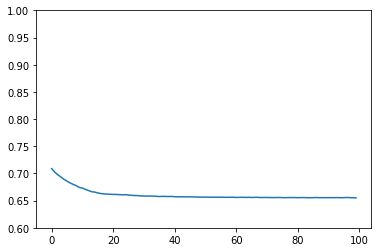

In [46]:
#h['loss']
plt.plot(range(100), h.history['loss'])
plt.ylim([0.6, 1])

In [ ]:
#def accuracy(preds, labels):
#    return np.mean(np.equal(np.argmax(labels, 1), np.argmax(preds, 1)))

#def evaluate_preds(preds, labels, indices):

#    split_loss = list()
#    split_acc = list()

#    for y_split, idx_split in zip(labels, indices):
#        split_loss.append(categorical_crossentropy(preds[idx_split], y_split[idx_split]))
#        split_acc.append(accuracy(preds[idx_split], y_split[idx_split]))

#    return split_loss, split_acc

In [ ]:
# Fit
#for epoch in range(1, NB_EPOCH+1):
#    t = time.time()
#    model.fit(graph, y_train, sample_weight=train_mask,
#              batch_size=A.shape[0], epochs=1, shuffle=False, verbose=1)
#    preds = model.predict(graph, batch_size=A.shape[0])
    
    # Train / validation scores
    #train_val_loss, train_val_acc = evaluate_preds(preds, [y_train, y_val],
    #                                               [idx_train, idx_val])
    #print("Epoch: {:04d}".format(epoch),
    #      "train_loss= {:.4f}".format(train_val_loss[0]),
    #      "train_acc= {:.4f}".format(train_val_acc[0]),
    #      "val_loss= {:.4f}".format(train_val_loss[1]),
    #      "val_acc= {:.4f}".format(train_val_acc[1]),
    #      "time= {:.4f}".format(time.time() - t))

    # Early stopping
    #if train_val_loss[1] < best_val_loss:
    #    best_val_loss = train_val_loss[1]
    #    wait = 0
    #else:
    #    if wait >= PATIENCE:
    #        print('Epoch {}: early stopping'.format(epoch))
    #        break
    #    wait += 1

In [25]:
preds[:,1]

array([ 0.63996005,  0.63444799,  0.63520533,  0.64009714,  0.63234168,
        0.63747787,  0.63825715,  0.63770497,  0.64345545,  0.63573956,
        0.64391965,  0.64381993,  0.63777018,  0.64152914,  0.63753581,
        0.64364851,  0.64399827,  0.64256948,  0.64305782,  0.63900357,
        0.64046633,  0.63822848,  0.63812447,  0.64194053,  0.64130247,
        0.64543968,  0.64205146,  0.64393175,  0.64007658,  0.63747674,
        0.63492054,  0.63923603,  0.63794911,  0.63619268,  0.64514226,
        0.63911515,  0.64275992,  0.63656229,  0.62794489,  0.644786  ,
        0.64489186,  0.64151686,  0.6425736 ,  0.64105469,  0.63920271,
        0.64203387,  0.64175683,  0.64177012,  0.64199787,  0.64499164,
        0.64530486,  0.64223486,  0.64069086,  0.63611156,  0.6429525 ,
        0.63480586,  0.64016277,  0.64062309,  0.63763011,  0.6409412 ,
        0.6449827 ,  0.64520359,  0.63978857,  0.64492613,  0.64120322,
        0.64479399,  0.64503801,  0.6391592 ,  0.64515334,  0.64

In [24]:
preds = model.predict(graph, batch_size=A.shape[0])

In [223]:
# Testing
test_loss, test_acc = evaluate_preds(preds, [y_test], [idx_test])
print("Test set results:",
      "loss= {:.4f}".format(test_loss[0]),
      "accuracy= {:.4f}".format(test_acc[0]))

Test set results: loss= 0.6414 accuracy= 0.0023
